In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_pipeline.fetcher.yfinance_fetcher import fetch_ohlcv
from models.monte_carlo import MonteCarloSimulator, plot_simulations, plot_final_distribution

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Help on function fetch_ohlcv in module data_pipeline.fetcher.yfinance_fetcher:

fetch_ohlcv(ticker: str, start: str = '2020-01-01', end: str = None, interval: str = '1d') -> pandas.core.frame.DataFrame
    Download OHLCV data from Yahoo Finance(ticker):
    Args:
        ticker (str): ticker symbol
        start (str, optional): start date
        end (str, optional): end date
        interval (str, optional): interval

    Returns:
        pd.DataFrame: OHLCV data

Help on function fetch_multiple_tickers in module data_pipeline.fetcher.yfinance_fetcher:

fetch_multiple_tickers(tickers: list, **kwargs) -> pandas.core.frame.DataFrame
    Fetching data for multiple tickers onto one dataframe.
    Args:
        tickers (list): list of tickers
        **kwargs:
    Returns:
     pd.DataFrame: OHLCV data



In [2]:
ticker = 'AAPL'
df = fetch_ohlcv(ticker,start='2020-01-01')
df.tail()

2025-10-04 22:05:52,042  - INFO - Fetching OHLCV data from AAPL from 2020-01-01 to  2025-10-04
2025-10-04 22:05:52,942  - INFO - Downloaded 1447 rows for ticker AAPL


,date,open,high,low,close,adj_close,volume,dividends,splits,ticker
1442,2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,254.429993,40127700,0.0,0.0,AAPL
1443,2025-09-30 00:00:00-04:00,254.860001,255.919998,253.110001,254.630005,254.630005,37704300,0.0,0.0,AAPL
1444,2025-10-01 00:00:00-04:00,255.039993,258.790009,254.929993,255.449997,255.449997,48713900,0.0,0.0,AAPL
1445,2025-10-02 00:00:00-04:00,256.579987,258.179993,254.149994,257.130005,257.130005,42630200,0.0,0.0,AAPL
1446,2025-10-03 00:00:00-04:00,254.669998,259.239990,253.949997,258.019989,258.019989,49107000,0.0,0.0,AAPL


In [3]:
simulator = MonteCarloSimulator(seed=42)
mu,sigma = simulator.estimate_parameters(df['adj_close'])

print(f'''Drift : {mu: .2f} annually''')
print(f'''Volatility : {sigma: .2f} annually''')
print(f''' last price: {simulator.S0: .2f} annually''')

2025-10-04 22:05:53,445  - INFO - Estimated params: mu = 0.22113946592860523, sigma = 5.111573738619205
2025-10-04 22:05:53,445  - INFO - Starting price:  258.02


Drift :  0.22 annually
Volatility :  5.11 annually
 last price:  258.02 annually


In [4]:
T_days = 30
n_simulations = 10000

#starting
price_paths = simulator.simulate(
    S0=simulator.S0,
    mu = mu,
    sigma = sigma,
    T=T_days,
    n_simulations = n_simulations,
)
price_paths.shape

2025-10-04 22:05:53,608  - INFO - Starting 10000 simulations on 30 days
2025-10-04 22:05:53,622  - INFO - Simulation finishe. Shape: (10000, 31)


(10000, 31)

In [5]:
stats = simulator.get_statistics(price_paths)
print(f'Median: {stats['median'][-1]: .2f}')
print(f'Mean: {stats['mean'][-1]: .2f}')
print(f'5th percentile: {stats['percentile_5'][-1]: .2f}')
print(f'95th percentile: {stats['percentile_95'][-1]: .2f}')

Median:  58.01
Mean:  270.94
5th percentile:  2.89
95th percentile:  1010.94


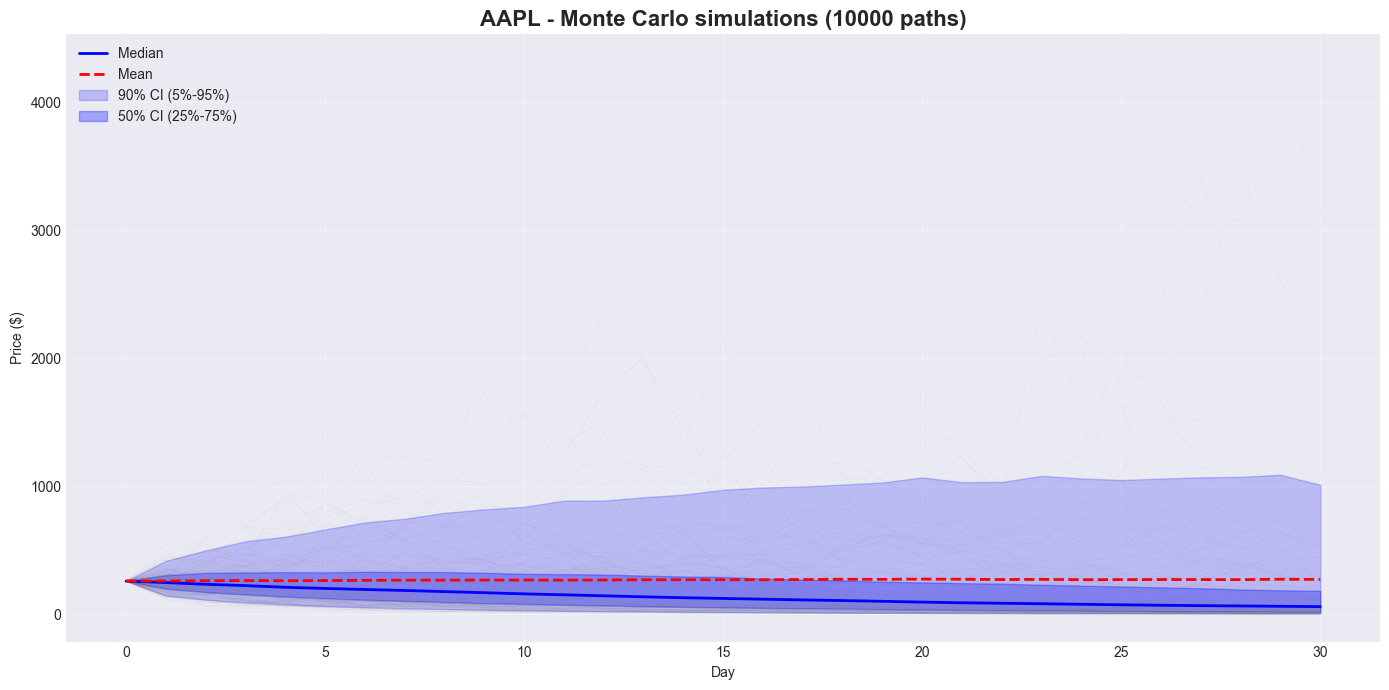

In [6]:
plot_simulations(price_paths,stats,ticker,n_paths_to_plot=200)

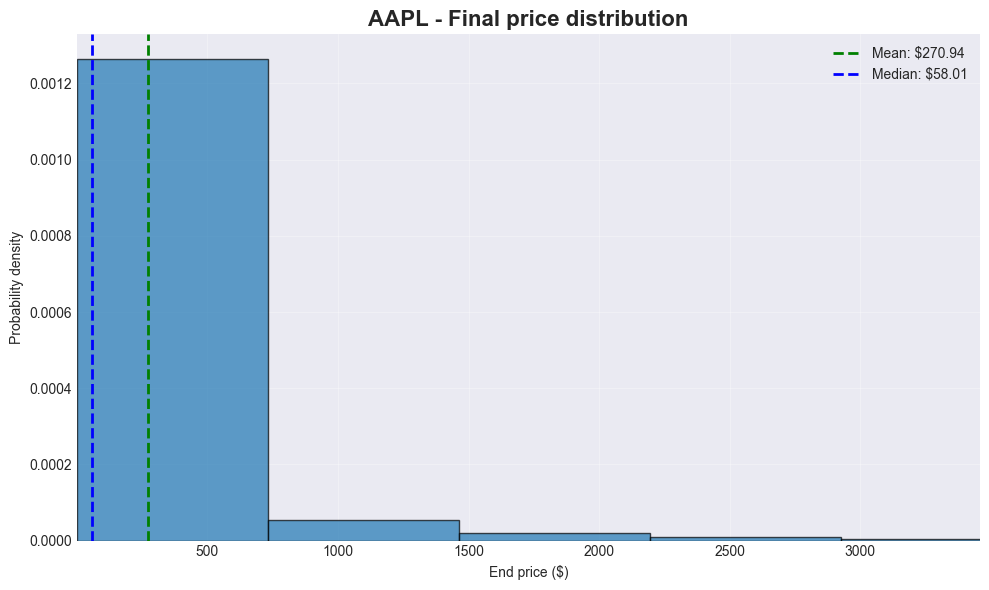

In [7]:
plot_final_distribution(price_paths,ticker)

In [8]:
risk_metrics = simulator.calculate_risk_metrics(price_paths,confidence_level=0.95)

print(f'Expected return: {risk_metrics['expected_return']: .2%}')
print(f'Best possible return: {risk_metrics["best_case"]: .2%}')
print(f'Worst possible return: {risk_metrics["worst_case"]: .2%}')

print(f'VaR(95%): {risk_metrics['var_95']: .2%}')
print(f'Expected Shortfall: {risk_metrics["expected_shortfall"]: .2%}')
print(f'Standard Deviation: {risk_metrics["std_return"]: .2%}')

print(f'P(return): {risk_metrics["probability_profit"]: .2%}')

2025-10-04 22:05:54,349  - INFO - Risk metrics:(Var 95%: -98.88%)


Expected return:  5.01%
Best possible return:  28258.61%
Worst possible return: -99.95%
VaR(95%): -98.88%
Expected Shortfall: -99.37%
Standard Deviation:  461.18%
P(return):  18.88%


## Return Metrics
- **Expected return:** average expected return from the simulations
- **Best case scenario:** the most optimistic outcome observed in the simulations
- **Worst case scenario:** the most pessimistic outcome observed in the simulations

---

## Risk Metrics
- **Value at Risk (95%):** maximum expected loss at the 5% worst outcomes
- **Expected Shortfall (CVaR):** average loss given that the result falls within the worst 5%
- **Standard Deviation of returns:** measure of volatility in the simulated outcomes

---

## Probabilities
- **Probability of profit:** the proportion of simulations that ended with a positive return

---

## Interpretation
- **VaR (95%)**: In 95% of cases, losses should not exceed this threshold.
- **Expected Shortfall (CVaR)**: If results fall within the worst 5% of scenarios, the average loss will be around this level.
- **Probability of profit**: Indicates how often the simulations produced a gain rather than a loss.



In [9]:
current_price = simulator.S0
targets = [
    current_price*0,95,
    current_price*1,
    current_price*1.05,
    current_price*1.1,
    current_price*1.15,
]
#probability of reaching the goal
probabilities = []
for target in targets:
    prob = simulator.probability_above_target(price_paths, target)
    probabilities.append(prob)
    change_pct = (target / current_price - 1)*100
    print(f'Price >= {target: .2f} ({change_pct:+.1f}%): {prob:.1%}')


2025-10-04 22:05:54,389  - INFO - P(price >= $ 0.00) = 1.00
2025-10-04 22:05:54,391  - INFO - P(price >= $ 95.00) = 0.39
2025-10-04 22:05:54,392  - INFO - P(price >= $ 258.02) = 0.19
2025-10-04 22:05:54,393  - INFO - P(price >= $ 270.92) = 0.18
2025-10-04 22:05:54,394  - INFO - P(price >= $ 283.82) = 0.17
2025-10-04 22:05:54,395  - INFO - P(price >= $ 296.72) = 0.17


Price >=  0.00 (-100.0%): 100.0%
Price >=  95.00 (-63.2%): 38.6%
Price >=  258.02 (+0.0%): 18.9%
Price >=  270.92 (+5.0%): 18.0%
Price >=  283.82 (+10.0%): 17.4%
Price >=  296.72 (+15.0%): 16.9%


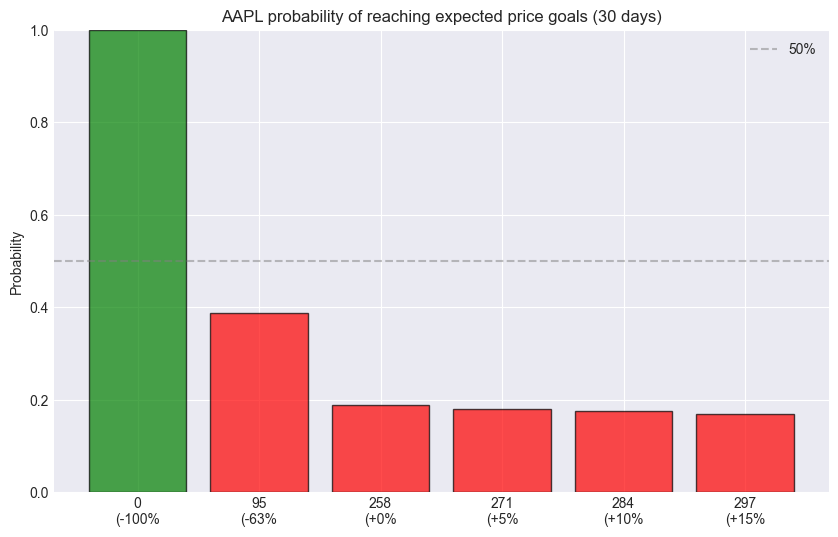

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

target_labels = [f'{t:.0f}\n({(t/current_price-1)*100:+.0f}%' for t in targets]
colors = ['red' if p<0.5 else 'green' for p in probabilities]
bars = ax.bar(range(len(targets)),probabilities,color=colors, alpha = 0.7, edgecolor='black')
ax.set_xticks(range(len(targets)))
ax.set_xticklabels(target_labels)
ax.set_ylabel('Probability')
ax.set_title(f'{ticker} probability of reaching expected price goals ({T_days} days)')
ax.axhline(y=0.5,color='gray',linestyle='--',alpha=0.5,label='50%')
ax.set_ylim(0,1)
ax.legend()

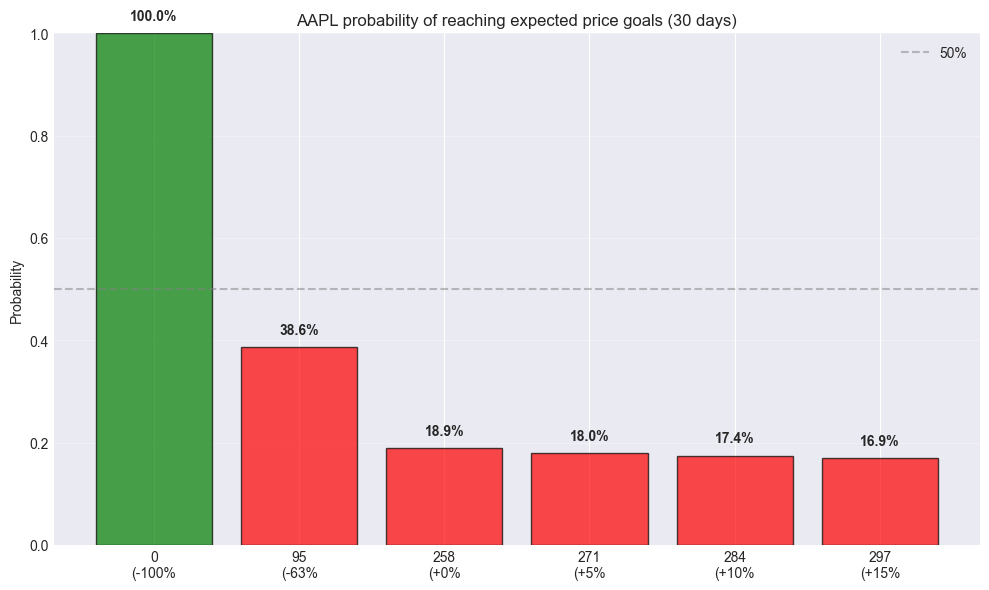

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

target_labels = [f'{t:.0f}\n({(t/current_price-1)*100:+.0f}%' for t in targets]
colors = ['red' if p<0.5 else 'green' for p in probabilities]
bars = ax.bar(range(len(targets)),probabilities,color=colors, alpha = 0.7, edgecolor='black')
ax.set_xticks(range(len(targets)))
ax.set_xticklabels(target_labels)
ax.set_ylabel('Probability')
ax.set_title(f'{ticker} probability of reaching expected price goals ({T_days} days)')
ax.axhline(y=0.5,color='gray',linestyle='--',alpha=0.5,label='50%')
ax.set_ylim(0,1)
ax.legend()
for i, (bar,prob) in enumerate(zip(bars, probabilities)):
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2., height + 0.02,
            f'{prob:.1%}',ha='center',va='bottom',fontweight='bold')

plt.grid(True,alpha=0.3,axis='y')
plt.tight_layout()
plt.show()

In [12]:
time_horizons = [7,30,90,252]
horizon_stats = {}

for T in time_horizons:
    paths = simulator.simulate(simulator.S0,mu,sigma,T,n_simulations=5000)
    stats_T = simulator.get_statistics(paths)
    risk_T = simulator.calculate_risk_metrics(paths)

    horizon_stats[T] = {
        'median': stats_T['median'][-1],
        'p5':stats_T['percentile_5'][-1],
        'p95':stats_T['percentile_95'][-1],
        'var':risk_T['var_95'],
        'prob_profit':risk_T['probability_profit'],
    }
    print(f"   {T:3d} days: median=${stats_T['median'][-1]:.2f}, VaR={risk_T['var_95']:.2%}")

2025-10-04 22:05:54,662  - INFO - Starting 5000 simulations on 7 days
2025-10-04 22:05:54,663  - INFO - Simulation finishe. Shape: (5000, 8)
2025-10-04 22:05:54,668  - INFO - Risk metrics:(Var 95%: -82.27%)
2025-10-04 22:05:54,669  - INFO - Starting 5000 simulations on 30 days
2025-10-04 22:05:54,674  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-04 22:05:54,690  - INFO - Risk metrics:(Var 95%: -98.84%)
2025-10-04 22:05:54,690  - INFO - Starting 5000 simulations on 90 days
2025-10-04 22:05:54,704  - INFO - Simulation finishe. Shape: (5000, 91)


     7 days: median=$179.22, VaR=-82.27%
    30 days: median=$58.59, VaR=-98.84%


2025-10-04 22:05:54,737  - INFO - Risk metrics:(Var 95%: -99.99%)
2025-10-04 22:05:54,737  - INFO - Starting 5000 simulations on 252 days
2025-10-04 22:05:54,776  - INFO - Simulation finishe. Shape: (5000, 253)


    90 days: median=$2.53, VaR=-99.99%


2025-10-04 22:05:54,874  - INFO - Risk metrics:(Var 95%: -100.00%)


   252 days: median=$0.00, VaR=-100.00%


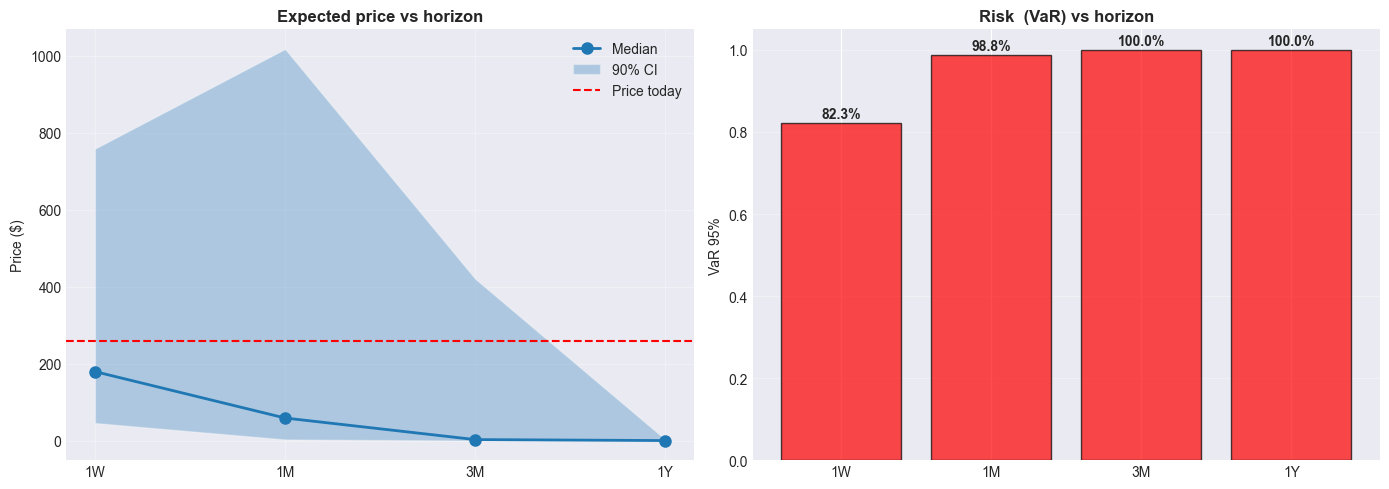

In [13]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
horizon_labels = ['1W','1M','3M','1Y']
medians = [horizon_stats[T]['median'] for T in time_horizons]
p5s = [horizon_stats[T]['p5'] for T in time_horizons]
p95s = [horizon_stats[T]['p95'] for T in time_horizons]
x_pos = np.arange(len(time_horizons))
axes[0].plot(x_pos,medians,marker='o',linewidth=2,markersize=8,label='Median')
axes[0].fill_between(x_pos,p5s,p95s,label='90% CI',alpha=0.3)
axes[0].axhline(y=simulator.S0,color='red',linestyle='--',label='Price today')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(horizon_labels)
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Expected price vs horizon',fontweight='bold')
axes[0].legend()
axes[0].grid(True,alpha=0.3)

vars_list = [horizon_stats[T]['var'] for T in time_horizons]
axes[1].bar(x_pos,[abs(v) for v in vars_list], alpha=0.7,color='red',edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(horizon_labels)
axes[1].set_ylabel('VaR 95%')
axes[1].set_title('Risk  (VaR) vs horizon',fontweight='bold')
axes[1].grid(True,alpha=0.3,axis='y')

for i,v in enumerate(vars_list):
    axes[1].text(i,abs(v)+0.005,f'{abs(v):.1%}',ha='center',va='bottom',fontweight='bold')

plt.tight_layout()
plt.show()



In [14]:
tickers_to_compare = ['AAPL','MSFT','TSLA','SPY']
comparison_results = {}

for tick in tickers_to_compare:
    df_temp = fetch_ohlcv(tick,start='2020-01-01')
    if df_temp.empty:
        continue
    sim_temp = MonteCarloSimulator(42)
    mu_temp, sigma_temp = sim_temp.estimate_parameters(df_temp['adj_close'])
    paths_temp = sim_temp.simulate(sim_temp.S0,mu_temp,sigma_temp,30,5000)
    risk_temp = sim_temp.calculate_risk_metrics(paths_temp)

    comparison_results[tick] = {
        'mu': mu_temp,
        'sigma': sigma_temp,
        'current_price': sim_temp.S0,
        'expected_return': risk_temp['expected_return'],
        'var_95': risk_temp['var_95'],
        'prob_profit': risk_temp['probability_profit']
    }
    print(f'{tick:6s}: mu={mu_temp:6.2%}, sigma={sigma_temp:6.2%}, '
      f'E[R]={risk_temp["expected_return"]:6.2%}, VaR={risk_temp["var_95"]:6.2%}')






2025-10-04 22:05:55,069  - INFO - Fetching OHLCV data from AAPL from 2020-01-01 to  2025-10-04
2025-10-04 22:05:55,091  - INFO - Downloaded 1447 rows for ticker AAPL
2025-10-04 22:05:55,093  - INFO - Estimated params: mu = 0.22113946592860523, sigma = 5.111573738619205
2025-10-04 22:05:55,094  - INFO - Starting price:  258.02
2025-10-04 22:05:55,095  - INFO - Starting 5000 simulations on 30 days
2025-10-04 22:05:55,101  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-04 22:05:55,102  - INFO - Risk metrics:(Var 95%: -98.84%)
2025-10-04 22:05:55,103  - INFO - Fetching OHLCV data from MSFT from 2020-01-01 to  2025-10-04


AAPL  : mu=22.11%, sigma=511.16%, E[R]= 8.80%, VaR=-98.84%


2025-10-04 22:05:55,321  - INFO - Downloaded 1447 rows for ticker MSFT
2025-10-04 22:05:55,323  - INFO - Estimated params: mu = 0.2125527295113402, sigma = 4.745444962524304
2025-10-04 22:05:55,324  - INFO - Starting price:  517.35
2025-10-04 22:05:55,324  - INFO - Starting 5000 simulations on 30 days
2025-10-04 22:05:55,330  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-04 22:05:55,332  - INFO - Risk metrics:(Var 95%: -98.23%)
2025-10-04 22:05:55,332  - INFO - Fetching OHLCV data from TSLA from 2020-01-01 to  2025-10-04


MSFT  : mu=21.26%, sigma=474.54%, E[R]= 7.69%, VaR=-98.23%


2025-10-04 22:05:55,540  - INFO - Downloaded 1447 rows for ticker TSLA
2025-10-04 22:05:55,541  - INFO - Estimated params: mu = 0.4717680975239649, sigma = 10.650227326786343
2025-10-04 22:05:55,542  - INFO - Starting price:  429.83
2025-10-04 22:05:55,542  - INFO - Starting 5000 simulations on 30 days
2025-10-04 22:05:55,548  - INFO - Simulation finishe. Shape: (5000, 31)
2025-10-04 22:05:55,548  - INFO - Risk metrics:(Var 95%: -100.00%)
2025-10-04 22:05:55,550  - INFO - Fetching OHLCV data from SPY from 2020-01-01 to  2025-10-04
2025-10-04 22:05:55,727  - INFO - Downloaded 1447 rows for ticker SPY
2025-10-04 22:05:55,728  - INFO - Estimated params: mu = 0.14065025938354397, sigma = 3.344283644958662
2025-10-04 22:05:55,730  - INFO - Starting price:  669.21
2025-10-04 22:05:55,730  - INFO - Starting 5000 simulations on 30 days
2025-10-04 22:05:55,735  - INFO - Simulation finishe. Shape: (5000, 31)


TSLA  : mu=47.18%, sigma=1065.02%, E[R]=32.40%, VaR=-100.00%


2025-10-04 22:05:55,737  - INFO - Risk metrics:(Var 95%: -92.32%)


SPY   : mu=14.07%, sigma=334.43%, E[R]= 4.18%, VaR=-92.32%


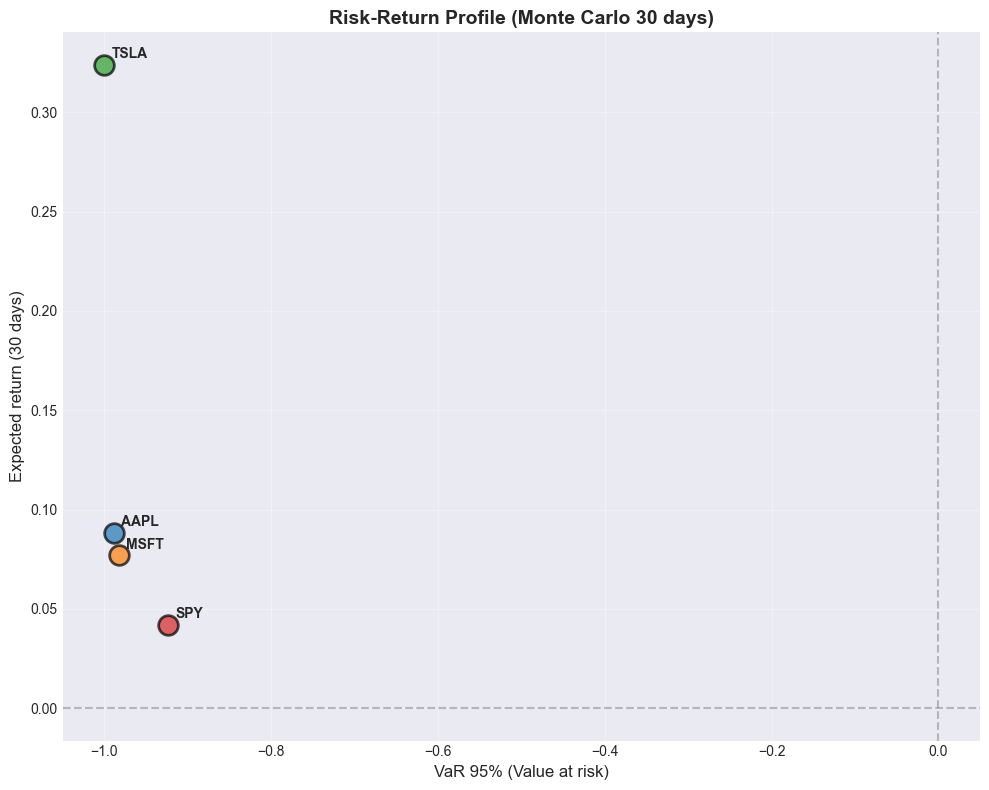

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
for tick, results in comparison_results.items():
    ax.scatter(results['var_95'],results['expected_return'],s=200,alpha=0.7,edgecolors='black',linewidth=2)
    ax.annotate(tick,(results['var_95'],results['expected_return']),xytext=(5,5),textcoords='offset points',fontweight='bold')

ax.axhline(y=0,color='gray',linestyle='--',alpha=0.5)
ax.axvline(x=0,color='gray',linestyle='--',alpha=0.5)
ax.set_xlabel('VaR 95% (Value at risk)',fontsize=12)
ax.set_ylabel('Expected return (30 days)', fontsize=12)
ax.set_title('Risk-Return Profile (Monte Carlo 30 days)',fontweight='bold', fontsize=14)
ax.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()




In [16]:
base_mu = mu
base_sigma = sigma
sigma_multipliers = [0.5,0.75,1.0,1.25,1.5]
sensitivity_results = {}

for mult in sigma_multipliers:
    test_sigma = base_sigma * mult
    paths_test = simulator.simulate(simulator.S0,base_mu,test_sigma,30,3000)
    stats_test = simulator.get_statistics(paths_test)
    risk_test = simulator.calculate_risk_metrics(paths_test)

    sensitivity_results[mult] = {
        'sigma': test_sigma,
        'median':stats_test['median'][-1],
        'var':risk_test['var_95'],
        'expected_return':risk_test['expected_return']
    }
    print(f' sigma x {mult:.2f} = {test_sigma:0.2%}',
          f'VaR = {risk_test['var_95']:.2%}, E[R] = {risk_test['expected_return']:.2%}')

2025-10-04 22:17:36,541  - INFO - Starting 3000 simulations on 30 days
2025-10-04 22:17:36,545  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-04 22:17:36,554  - INFO - Risk metrics:(Var 95%: -84.20%)
2025-10-04 22:17:36,555  - INFO - Starting 3000 simulations on 30 days
2025-10-04 22:17:36,557  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-04 22:17:36,564  - INFO - Risk metrics:(Var 95%: -95.37%)
2025-10-04 22:17:36,565  - INFO - Starting 3000 simulations on 30 days
2025-10-04 22:17:36,569  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-04 22:17:36,577  - INFO - Risk metrics:(Var 95%: -98.88%)
2025-10-04 22:17:36,577  - INFO - Starting 3000 simulations on 30 days
2025-10-04 22:17:36,580  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-04 22:17:36,588  - INFO - Risk metrics:(Var 95%: -99.78%)
2025-10-04 22:17:36,588  - INFO - Starting 3000 simulations on 30 days
2025-10-04 22:17:36,591  - INFO - Simulation finishe. Shape: (3000, 31)
2025-10-04 22:17:36,5

 sigma x 0.50 = 255.58% VaR = -84.20%, E[R] = 5.91%
 sigma x 0.75 = 383.37% VaR = -95.37%, E[R] = 10.32%
 sigma x 1.00 = 511.16% VaR = -98.88%, E[R] = 18.48%
 sigma x 1.25 = 638.95% VaR = -99.78%, E[R] = 32.45%
 sigma x 1.50 = 766.74% VaR = -99.96%, E[R] = 52.91%


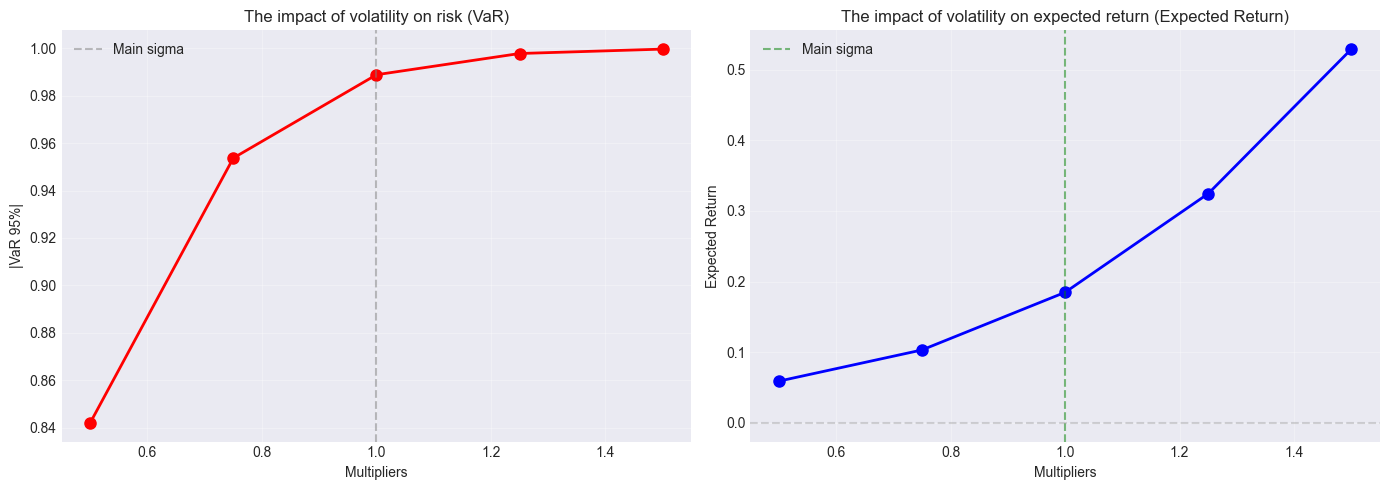

   Higher volatility (σ) → higher VaR (greater risk)
   But note: in GBM, higher σ → lower expected return!
   (because of the -0.5σ² term in the drift formula)


In [18]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

multipliers = list(sensitivity_results.keys())
vars_sens = [abs(sensitivity_results[m]['var']) for m in multipliers]
expected_returns = [sensitivity_results[m]['expected_return'] for m in multipliers]

axes[0].plot(multipliers,vars_sens,marker='o',linewidth=2,markersize=8,color='red')
axes[0].set_xlabel('Multipliers')
axes[0].set_ylabel('|VaR 95%|')
axes[0].set_title('The impact of volatility on risk (VaR)')
axes[0].grid(True,alpha=0.3)
axes[0].axvline(x=1.0,color='gray',linestyle='--',alpha=0.5,label='Main sigma')
axes[0].legend()

axes[1].plot(multipliers,expected_returns,marker='o',linewidth=2,markersize=8,color='blue')
axes[1].set_xlabel('Multipliers')
axes[1].set_ylabel('Expected Return')
axes[1].set_title('The impact of volatility on expected return (Expected Return)')
axes[1].grid(True,alpha=0.3)
axes[1].axvline(x=1.0,color='green',linestyle='--',alpha=0.5,label='Main sigma')
axes[1].axhline(y=0,color='gray',linestyle='--',alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("   Higher volatility (σ) → higher VaR (greater risk)")
print("   But note: in GBM, higher σ → lower expected return!")
print("   (because of the -0.5σ² term in the drift formula)")



2025-10-04 22:39:16,919  - INFO - Starting 10000 simulations on 30 days
2025-10-04 22:39:16,930  - INFO - Simulation finishe. Shape: (10000, 31)
2025-10-04 22:39:16,932  - INFO - Risk metrics:(Var 95%: -98.88%)



 I want to invest 10000$ in AAPL for 30 days
Actual price:  258.02
I'm buying 38.76 shares

 Result of simulation (30 days)
 Portfolio values (median): 224846.10%$
 Expected return: 50061.60%$
Scenerios
 Return: 188800.00% (18.88%)
 Loss: 811200.00% (81.12%)
   VaR (95%): $9,887.94 (-98.88%)
   Expected Shortfall: $9,936.71 (-99.37%)
   → In  5% scenerios I will loss avg  $9,936.71


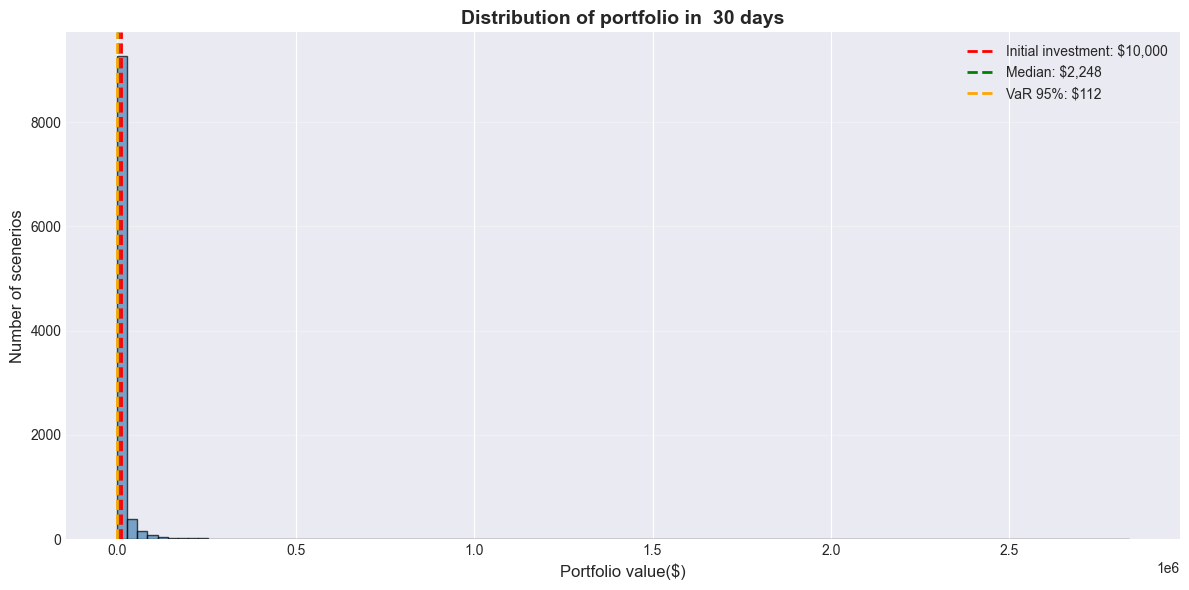

In [22]:
#Decision sample
decision_ticker = 'AAPL'
decision_horizon=30
investment = 10000

print(f'\n I want to invest {investment:.0f}$ in {decision_ticker} for {decision_horizon} days')
print(f'Actual price: {simulator.S0: .2f}')
n_shares = investment/simulator.S0
print(f"I'm buying {n_shares:.2f} shares")

decision_paths = simulator.simulate(simulator.S0,mu,sigma,decision_horizon,10000)
decision_risk = simulator.calculate_risk_metrics(decision_paths)

portfolio_values = decision_paths[:,-1]*n_shares
print(f"\n Result of simulation ({decision_horizon} days)")
print(f" Portfolio values (median): {np.median(portfolio_values):.2%}$")
print(f" Expected return: {portfolio_values.mean()-investment:.2%}$")

profit_scenerios = (portfolio_values > investment).sum()
loss_scenarios = (portfolio_values < investment).sum()

print(f"Scenerios")
print(f" Return: {profit_scenerios:.2%} ({profit_scenerios/len(portfolio_values):.2%})")
print(f" Loss: {loss_scenarios:.2%} ({loss_scenarios/len(portfolio_values):.2%})")

var_dollars = investment * abs(decision_risk['var_95'])
es_dollars = investment * abs(decision_risk['expected_shortfall'])

print(f"   VaR (95%): ${var_dollars:,.2f} ({decision_risk['var_95']:.2%})")
print(f"   Expected Shortfall: ${es_dollars:,.2f} ({decision_risk['expected_shortfall']:.2%})")
print(f"   → In  5% scenerios I will loss avg  ${es_dollars:,.2f}")

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(portfolio_values, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(investment, color='red', linestyle='--', linewidth=2,
           label=f'Initial investment: ${investment:,.0f}')
ax.axvline(np.median(portfolio_values), color='green', linestyle='--', linewidth=2,
           label=f'Median: ${np.median(portfolio_values):,.0f}')

# VaR threshold
var_threshold = investment * (1 + decision_risk['var_95'])
ax.axvline(var_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'VaR 95%: ${var_threshold:,.0f}')

ax.set_xlabel('Portfolio value($)', fontsize=12)
ax.set_ylabel('Number of scenerios', fontsize=12)
ax.set_title(f'Distribution of portfolio in  {decision_horizon} days',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

bad numbers, stopped coding for a while
